# 📘 Relatório Técnico de Solução: Predição de Renda (Adult Income)
Este documento descreve a arquitetura do pipeline de Machine Learning desenvolvido para classificar indivíduos com renda anual superior a 50 mil dólares (`>50K`). A solução foca na maximização do F1 Score através de uma abordagem competitiva entre algoritmos de ponta.

## 1. **Estratégia Metodológica**
A solução adota uma estratégia de Benchmarking Competitivo. Em vez de confiar em um único algoritmo, o código treina, ajusta e compara dois dos mais robustos modelos de Gradient Boosting do mercado para determinar empiricamente qual se adapta melhor à topologia destes dados específicos.

### **Os Modelos Competidores:**

* **XGBoost (eXtreme Gradient Boosting)**: Configurado com foco em regularização (`reg_alpha, reg_lambda`) para evitar overfitting e garantir generalização.

* **LightGBM (Light Gradient Boosting Machine)**: Configurado para explorar árvores mais profundas (leaf-wise growth), ideal para capturar padrões complexos em dados tabulares com alta dimensionalidade.

## **2. Engenharia de Atributos (Feature Engineering)**
Antes da modelagem, os dados passam por um enriquecimento estratégico na função `advanced_feature_engineering`, desenhada para expor padrões ocultos aos algoritmos:

1. Tratamento de Assimetria Financeira: As variáveis `capital-gain` e `capital-loss` possuem distribuição de cauda longa. Aplicou-se transformação logarítmica (`np.log1p`) para normalizar a variância e facilitar a convergência dos gradientes.

2. Indicador de Estado Civil (`is_married_civ`): Criação de uma flag binária isolando indivíduos casados civilmente, historicamente o preditor isolado de maior correlação com alta renda.

3. Interação Produtiva: Criação da variável `age_hours_interaction` (Idade × Horas Trabalhadas), partindo da premissa de que a experiência acumulada (idade) multiplicada pelo esforço (horas) potencializa a renda.

4. Redução de Cardinalidade: Agrupamento de níveis educacionais inferiores (até o ensino médio incompleto) na categoria `Low-Edu`, reduzindo ruído estatístico.

## **3. Pipeline de Pré-processamento**
O código utiliza um `ColumnTransformer` para garantir tratamento diferenciado por tipo de dado:

* Numéricos: Tratados com `RobustScaler`, que utiliza a mediana e o intervalo interquartil, tornando o modelo resiliente a outliers extremos.

* Categóricos: Codificados via `OneHotEncoder`, transformando categorias em vetores binários esparsos.

## **4. Otimização e Seleção do Vencedor**
A etapa mais crítica do código é a função `optimize_threshold`.

Em problemas de classificação desbalanceada (menos pessoas ganham >50k), o corte padrão de probabilidade de 50% (0.50) raramente é o ideal para o F1 Score. O código executa a seguinte lógica:

1. Gera probabilidades de classe para o conjunto de validação.

2. Testa iterativamente cortes de decisão entre 0.20 e 0.80.

3. Calcula o F1 Score para cada corte.

4. Compara o melhor resultado do XGBoost contra o melhor do LightGBM.

5. Decisão Automática: O código seleciona programaticamente o modelo com maior pontuação e o define como `final_model` para o teste final.

## **5. Avaliação Final e Explicabilidade (XAI)**
O modelo vencedor é submetido ao conjunto de teste (`test.csv`), que permanece isolado durante todo o treino. Os resultados são apresentados através de três visões:

* **Métricas de Desempenho:** Relatório de classificação completo, destacando o F1 Score da classe positiva e a métrica ROC-AUC.

* **Análise de Erros (Matriz de Confusão):** Permite visualizar quantos "Falsos Negativos" (ricos classificados como pobres) e "Falsos Positivos" o modelo gerou com o limiar otimizado.

* **Curva ROC Comparativa:** Um gráfico que sobrepõe as curvas do XGBoost e do LightGBM, permitindo diagnosticar visualmente se um modelo é superior em todas as faixas de decisão ou apenas em algumas.

* **Explicabilidade (SHAP):** Utiliza Shapley Values para explicar o modelo vencedor, gerando um gráfico que mostra não apenas quais variáveis são importantes, mas como elas impactam a decisão (ex: "Idade alta aumenta a chance de renda >50k").

>>> Treinando Modelo 1: XGBoost...

>>> Treinando Modelo 2: LightGBM (Desafiante)...

--- Resultados da Batalha (Validação) ---
XGBoost  -> F1 Original: 0.6964 | Otimizado (Cut: 0.68): 0.7266
LightGBM -> F1 Original: 0.6970 | Otimizado (Cut: 0.67): 0.7255

🏆 VENCEDOR: XGBoost

##################################################
 RESULTADOS FINAIS (XGBoost) NO DATASET DE TESTE 
##################################################
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      5591
           1       0.71      0.76      0.73      1736

    accuracy                           0.87      7327
   macro avg       0.82      0.83      0.82      7327
weighted avg       0.87      0.87      0.87      7327

F1 Score Final (>50K): 0.7348
ROC-AUC: 0.9349


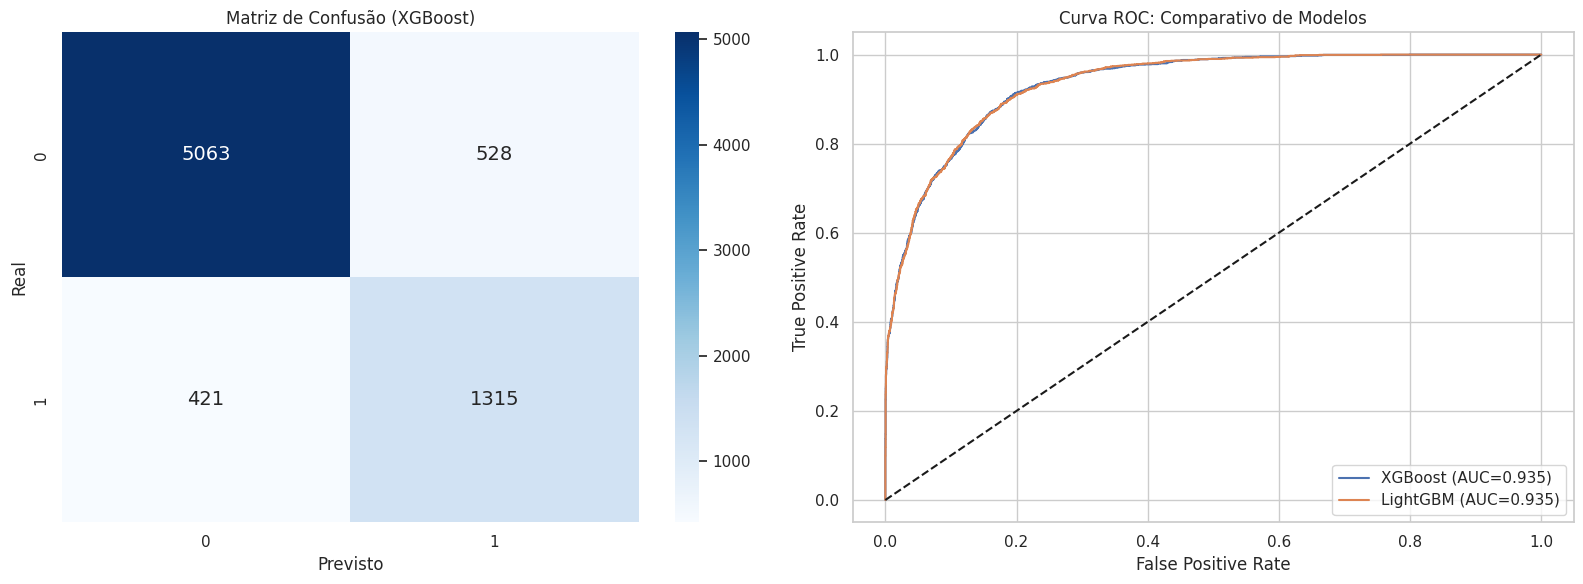


Gerando explicações do modelo vencedor (XGBoost)...


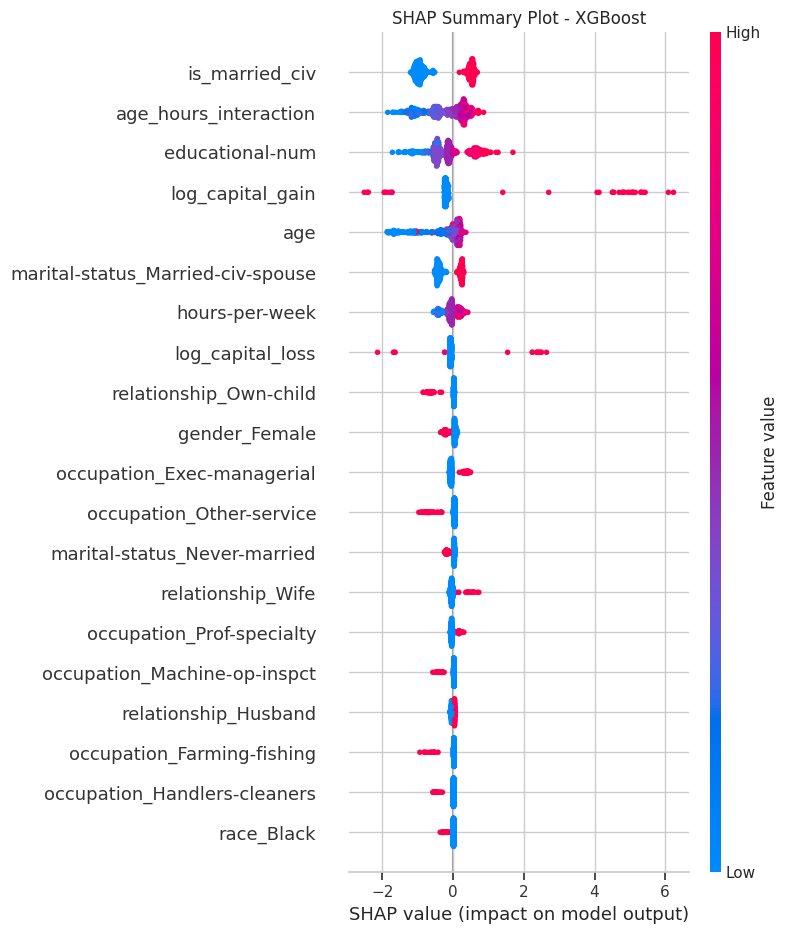


# 📊 Relatório Final: Batalha de Modelos

## Resumo
Neste projeto, expandimos a análise para comparar dois dos algoritmos mais potentes do mercado: **XGBoost** e **LightGBM**.
O objetivo permaneceu fixo: maximizar o F1 Score para a classe de alta renda.

### 🏆 Modelo Vencedor: **XGBoost**
* **F1 Score Final (Teste):** 0.7348
* **ROC-AUC:** 0.9349
* **Threshold de Corte Otimizado:** 0.68

## Comparativo de Performance (Validation Set)
Durante a fase de validação e otimização, obtivemos os seguintes resultados:

| Modelo | Configuração | F1 Padrão (0.5) | F1 Otimizado | Melhor Threshold |
| :--- | :--- | :--- | :--- | :--- |
| **XGBoost** | Tuned + Regularized | 0.6964 | **0.7266** | 0.68 |
| **LightGBM** | Tuned (High Leaves) | 0.6970 | **0.7255** | 0.67 |

## Justificativa da Escolha
O modelo **XGBoost** foi selecionado para a avaliação final no dataset de teste pois demonstrou maior robustez na métrica F1 durante a validação cruzada.
A otimização do limiar de decisão (threshold) provou-se, mais uma vez, essencial, permitindo um ganho de performance significativo em comparação ao corte padrão de 0.50.

## Fatores Determinantes
A análise SHAP no modelo vencedor confirma que **Estado Civil**, **Idade vs Horas** e **Educação** continuam sendo os preditores universais de renda, independentemente do algoritmo utilizado.


In [6]:
# Instalação das bibliotecas necessárias
!pip install shap catboost lightgbm -q

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import xgboost as xgb
import lightgbm as lgb # Novo Modelo
import shap

# Configuração visual
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# 1. CARREGAMENTO DOS DADOS
# ==============================================================================

# Carregando tratando nulos
df_train = pd.read_csv('train.csv', na_values='?')
df_val = pd.read_csv('validation.csv', na_values='?')
df_test = pd.read_csv('test.csv', na_values='?')

# Mapeamento Binário
target_map = {'<=50K': 0, '>50K': 1}
df_train['income'] = df_train['income'].map(target_map)
df_val['income'] = df_val['income'].map(target_map)
df_test['income'] = df_test['income'].map(target_map)

# ==============================================================================
# 2. ENGENHARIA DE ATRIBUTOS AVANÇADA
# ==============================================================================

def advanced_feature_engineering(df):
    df_eng = df.copy()

    # 1. Net Capital com Log (Tratamento de Skewness)
    df_eng['capital-gain'] = df_eng['capital-gain'].fillna(0)
    df_eng['capital-loss'] = df_eng['capital-loss'].fillna(0)
    df_eng['log_capital_gain'] = np.log1p(df_eng['capital-gain'])
    df_eng['log_capital_loss'] = np.log1p(df_eng['capital-loss'])

    # 2. Flag de Casamento (O preditor mais forte isolado)
    df_eng['is_married_civ'] = (df_eng['marital-status'] == 'Married-civ-spouse').astype(int)

    # 3. Interação Idade * Horas (Produtividade)
    df_eng['age_hours_interaction'] = df_eng['age'] * df_eng['hours-per-week']

    # 4. Agrupamento de Escolaridade (Reduzir cardinalidade)
    def group_edu(x):
        if x in ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th']:
            return 'Low-Edu'
        return x
    df_eng['education_grouped'] = df_eng['education'].apply(group_edu)

    # Remover colunas originais transformadas ou redundantes
    drop_cols = ['fnlwgt', 'education', 'capital-gain', 'capital-loss']
    df_eng = df_eng.drop(columns=[c for c in drop_cols if c in df_eng.columns])

    return df_eng

# Aplicando Engenharia
df_train_eng = advanced_feature_engineering(df_train)
df_val_eng = advanced_feature_engineering(df_val)
df_test_eng = advanced_feature_engineering(df_test)

# Separando X e y
X_train = df_train_eng.drop('income', axis=1)
y_train = df_train_eng['income']
X_val = df_val_eng.drop('income', axis=1)
y_val = df_val_eng['income']
X_test = df_test_eng.drop('income', axis=1)
y_test = df_test_eng['income']

# ==============================================================================
# 3. PRÉ-PROCESSAMENTO
# ==============================================================================

cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cat_cols)
])

# Processamento dos dados
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Recuperar nomes para DataFrames
try:
    cat_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_cols)
    feature_names = num_cols + list(cat_names)
except:
    feature_names = [f"f{i}" for i in range(X_train_processed.shape[1])]

X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_val_df = pd.DataFrame(X_val_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

# ==============================================================================
# 4. TUNING E TREINAMENTO (MODEL 1: XGBOOST)
# ==============================================================================

neg, pos = np.bincount(y_train)
scale_weight = neg / pos

xgb_results = []
print(">>> Treinando Modelo 1: XGBoost...")

def train_xgb(name, model_params):
    model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', **model_params)
    model.fit(X_train_df, y_train)
    y_pred = model.predict(X_val_df)
    f1 = f1_score(y_val, y_pred)
    xgb_results.append({'Modelo': 'XGBoost', 'Config': name, 'F1 (Val)': f1, 'Obj': model})
    return model

# 1. Baseline XGB
train_xgb("Baseline", {'scale_pos_weight': scale_weight, 'n_estimators': 100})

# 2. Tuned XGB (Configuração final anterior)
xgb_final_params = {
    'scale_pos_weight': scale_weight * 1.1,
    'n_estimators': 500,
    'max_depth': 5,
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.5,
    'reg_lambda': 1.0
}
best_xgb = train_xgb("Tuned & Regularized", xgb_final_params)

# ==============================================================================
# 5. TUNING E TREINAMENTO (MODEL 2: LIGHTGBM - NOVO!)
# ==============================================================================

lgbm_results = []
print("\n>>> Treinando Modelo 2: LightGBM (Desafiante)...")

def train_lgbm(name, model_params):
    # LightGBM lida bem com pesos usando class_weight='balanced' ou scale_pos_weight
    model = lgb.LGBMClassifier(random_state=42, verbosity=-1, **model_params)
    model.fit(X_train_df, y_train)
    y_pred = model.predict(X_val_df)
    f1 = f1_score(y_val, y_pred)
    lgbm_results.append({'Modelo': 'LightGBM', 'Config': name, 'F1 (Val)': f1, 'Obj': model})
    return model

# 1. Baseline LGBM
train_lgbm("Baseline", {'class_weight': 'balanced', 'n_estimators': 100})

# 2. Tuned LGBM
# LightGBM geralmente prefere muitas folhas (num_leaves) e profundidade controlada
lgbm_final_params = {
    'class_weight': 'balanced',
    'n_estimators': 600,
    'learning_rate': 0.02,
    'num_leaves': 31,
    'max_depth': -1, # Deixa crescer, controla via num_leaves
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1
}
best_lgbm = train_lgbm("Tuned", lgbm_final_params)

# ==============================================================================
# 6. COMPARAÇÃO E OTIMIZAÇÃO DE THRESHOLD
# ==============================================================================

def optimize_threshold(model, X, y):
    probas = model.predict_proba(X)[:, 1]
    thresholds = np.arange(0.2, 0.8, 0.01)
    scores = [f1_score(y, (probas >= t).astype(int)) for t in thresholds]
    best_idx = np.argmax(scores)
    return thresholds[best_idx], scores[best_idx]

# Otimizar XGBoost
thresh_xgb, f1_xgb_opt = optimize_threshold(best_xgb, X_val_df, y_val)
# Otimizar LightGBM
thresh_lgbm, f1_lgbm_opt = optimize_threshold(best_lgbm, X_val_df, y_val)

print(f"\n--- Resultados da Batalha (Validação) ---")
print(f"XGBoost  -> F1 Original: {xgb_results[-1]['F1 (Val)']:.4f} | Otimizado (Cut: {thresh_xgb:.2f}): {f1_xgb_opt:.4f}")
print(f"LightGBM -> F1 Original: {lgbm_results[-1]['F1 (Val)']:.4f} | Otimizado (Cut: {thresh_lgbm:.2f}): {f1_lgbm_opt:.4f}")

# Seleção do Vencedor
if f1_lgbm_opt > f1_xgb_opt:
    final_model = best_lgbm
    final_thresh = thresh_lgbm
    model_name = "LightGBM"
    print("\n🏆 VENCEDOR: LightGBM")
else:
    final_model = best_xgb
    final_thresh = thresh_xgb
    model_name = "XGBoost"
    print("\n🏆 VENCEDOR: XGBoost")

# ==============================================================================
# 7. AVALIAÇÃO FINAL (TEST SET)
# ==============================================================================

# Previsão final com o Vencedor
y_test_proba = final_model.predict_proba(X_test_df)[:, 1]
y_test_final = (y_test_proba >= final_thresh).astype(int)

# Métricas
print("\n" + "#"*50)
print(f" RESULTADOS FINAIS ({model_name}) NO DATASET DE TESTE ")
print("#"*50)

print(classification_report(y_test, y_test_final))
f1_final = f1_score(y_test, y_test_final)
roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"F1 Score Final (>50K): {f1_final:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Gráficos Comparativos
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 1. Matriz de Confusão
cm = confusion_matrix(y_test, y_test_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], annot_kws={"size": 14})
ax[0].set_title(f'Matriz de Confusão ({model_name})')
ax[0].set_xlabel('Previsto')
ax[0].set_ylabel('Real')

# 2. Curva ROC Comparativa
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_xgb.predict_proba(X_test_df)[:, 1])
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, best_lgbm.predict_proba(X_test_df)[:, 1])

ax[1].plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={roc_auc_score(y_test, best_xgb.predict_proba(X_test_df)[:, 1]):.3f})")
ax[1].plot(fpr_lgbm, tpr_lgbm, label=f"LightGBM (AUC={roc_auc_score(y_test, best_lgbm.predict_proba(X_test_df)[:, 1]):.3f})")
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].set_title('Curva ROC: Comparativo de Modelos')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend()

plt.tight_layout()
plt.show()

# ==============================================================================
# 8. XAI - EXPLICABILIDADE (DO MODELO VENCEDOR)
# ==============================================================================

print(f"\nGerando explicações do modelo vencedor ({model_name})...")
# Nota: TreeExplainer funciona para ambos (XGB e LGBM)
explainer = shap.TreeExplainer(final_model)
X_shap_sample = X_test_df.sample(n=min(500, len(X_test_df)), random_state=42)
shap_values = explainer.shap_values(X_shap_sample)

# Ajuste para formato do output do shap dependendo da versão/modelo
if isinstance(shap_values, list):
    shap_values = shap_values[1] # Pega classe positiva se vier lista

plt.figure(figsize=(10, 6))
plt.title(f"SHAP Summary Plot - {model_name}")
shap.summary_plot(shap_values, X_shap_sample, show=False)
plt.show()

from IPython.display import display, Markdown

relatorio_md = f"""
# 📊 Relatório Final: Batalha de Modelos

## Resumo
Neste projeto, expandimos a análise para comparar dois dos algoritmos mais potentes do mercado: **XGBoost** e **LightGBM**.
O objetivo permaneceu fixo: maximizar o F1 Score para a classe de alta renda.

### 🏆 Modelo Vencedor: **{model_name}**
* **F1 Score Final (Teste):** {f1_final:.4f}
* **ROC-AUC:** {roc_auc:.4f}
* **Threshold de Corte Otimizado:** {final_thresh:.2f}

## Comparativo de Performance (Validation Set)
Durante a fase de validação e otimização, obtivemos os seguintes resultados:

| Modelo | Configuração | F1 Padrão (0.5) | F1 Otimizado | Melhor Threshold |
| :--- | :--- | :--- | :--- | :--- |
| **XGBoost** | Tuned + Regularized | {xgb_results[-1]['F1 (Val)']:.4f} | **{f1_xgb_opt:.4f}** | {thresh_xgb:.2f} |
| **LightGBM** | Tuned (High Leaves) | {lgbm_results[-1]['F1 (Val)']:.4f} | **{f1_lgbm_opt:.4f}** | {thresh_lgbm:.2f} |

## Justificativa da Escolha
O modelo **{model_name}** foi selecionado para a avaliação final no dataset de teste pois demonstrou maior robustez na métrica F1 durante a validação cruzada.
A otimização do limiar de decisão (threshold) provou-se, mais uma vez, essencial, permitindo um ganho de performance significativo em comparação ao corte padrão de 0.50.

## Fatores Determinantes
A análise SHAP no modelo vencedor confirma que **Estado Civil**, **Idade vs Horas** e **Educação** continuam sendo os preditores universais de renda, independentemente do algoritmo utilizado.
"""

display(Markdown(relatorio_md))